# Trabalho Final de Machine Learning
Jean Tolotti

Análise de sentimentos utilizando processamento de linguagem natural (NLP) aplicado a um conjunto de tweets rankeados em Negativos e Positivos.

O dataset utilizado encontra-se em https://www.kaggle.com/kazanova/sentiment140 e para o correto funcionamento deste notebook, ele deve ser copiado para o filepath da plataforma em execução com o nome de data_set.csv.

Este trabalho foi desenvolvido no Google Colab, portanto o upload do arquivo foi feito pelo menu files.

### Descrição dos Dados
O dataset utilizado contém 1.600.000 tweets que estão classificados com uma nota para o sentimento de cada um deles, sendo 0 para negativo e 4 para positivo.

O CSV possui as seguintes colunas:
  - sentiment: Rank do sentimento (0=negativo, 4=positivo).
  - ids: ID do sistema origem.
  - date: Data em que o tweet foi publicado.
  - flag: Se houve query, se não = NO_QUERY.
  - user: Usuário que tweetou.
  - text: Texto do tweet.

### Importando pacotes e o Dataset

In [82]:
!pip install nltk

import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


dataset = pd.read_csv('data_set.csv', encoding='ISO-8859-1', names=["sentiment", "ids", "date", "flag", "user", "text"])
dataset.head(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Processamento dos dados
Primeiramente, podemos dropar as colunas que não serão utilizadas nessa análise. Portanto ficaremos apenas com a coluna de 'sentiment' e 'text', pois com elas conseguiremos alimentar nosso modelo.

In [83]:
dataset.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
dataset.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Podemos também alterar o valor do sentimento positivo de 4 para 1, assim facilita o entendimento e as análises.

In [84]:
dataset['sentiment'].replace(4, 1, inplace=True)
dataset.groupby('sentiment').describe()

text                                        
            count  unique                        top freq
sentiment                                                
0          800000  790185  isPlayer Has Died! Sorry   210
1          800000  793506              good morning   118

Identificamos acima que o dataset está equilibrado com 800mil registros positivos e 800mil registros negativos.

### Pré-processamento dos Textos
É importante notar que os dados que são obtidos no twitter sempre estarão suscetíveis a erros gramaticais, vícios de linguagem, escrita inconsistente, emojis em todos os lugares, verbos conjugados de variadas maneiras... Por conta disso é importante que haja um pré-processamento destes dados a fim de normalizá-los para facilitar a classificação por parte dos algoritmos.

Um exemplo de pré-processamento que faremos é a transformação de todos os textos em lowercase (minúsculo), outro exemplo é a remoção de URLs iniciadas por "http", "https" e "www", também removeremos os @nomeusuario por "USER". Caracteres que não são alfabéticos também serão removidos, além de palavras com menos de 2 letras e palavras com a mesma letra repetida muitas vezes.

Removeremos palavras que são irrelevantes, as chamadas stopwords, que são facilmente removidas com a biblioteca nltk. E após será aplicado a lematização que tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra, onde utilizaremos a mesma biblioteca nltk.

In [85]:
# Definindo todas as stopwords para a língua inglesa disponíveis na biblioteca nltk
stopwordlist = stopwords.words('english')

# Definindo os emojis que serão substituídos pelos seus significados
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}   

In [86]:
# Método responsável por aplicar as transformações necessárias para melhorar
# a qualidade dos textos analisados.
def preprocess(textdata):
    processedText = []
    
    # Lematização
    wordLemm = WordNetLemmatizer()
    
    # Regex para remoção de urls, usuários, não alfabéticos e repetições
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Substituindo cada possível url por ' URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Substituindo os emojis pelos seus valores
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        
        # Substituindo o @nomeusuario por 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        
        # Removendo todos textos não alfabéticos
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Substituindo repetições de caracteres excessivas
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Verificando se a palavra não é uma stopword
            if word not in stopwordlist:
                # Se não, verificar se tem 2 ou mais chars e lematizar
                if len(word) >= 2:
                    # Lematização das palavras
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [87]:
import time
t = time.time()

# Atribuindo os valores da coluna text a uma listae coluna sentiment a outra
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

processedtext = preprocess(text)
print(f'Pré-processamento de texto completo.')
print(f'Tempo total: {round(time.time()-t)}s')

Pré-processamento de texto completo.
Tempo total: 158s


### Análises
Agora que temos os textos já processados, podemos analisá-los neste estudo.

Montaremos um gráfico de WordCloud com as principais palavras positivas e negativas para facilitar a visualização.

Negativas:

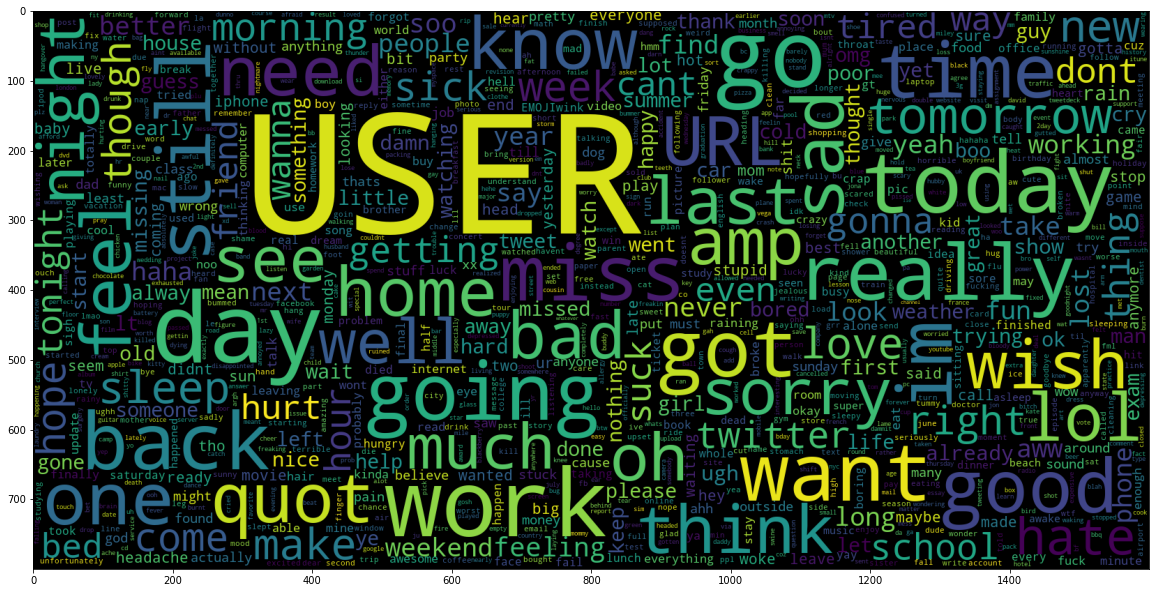

In [88]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Positivas:

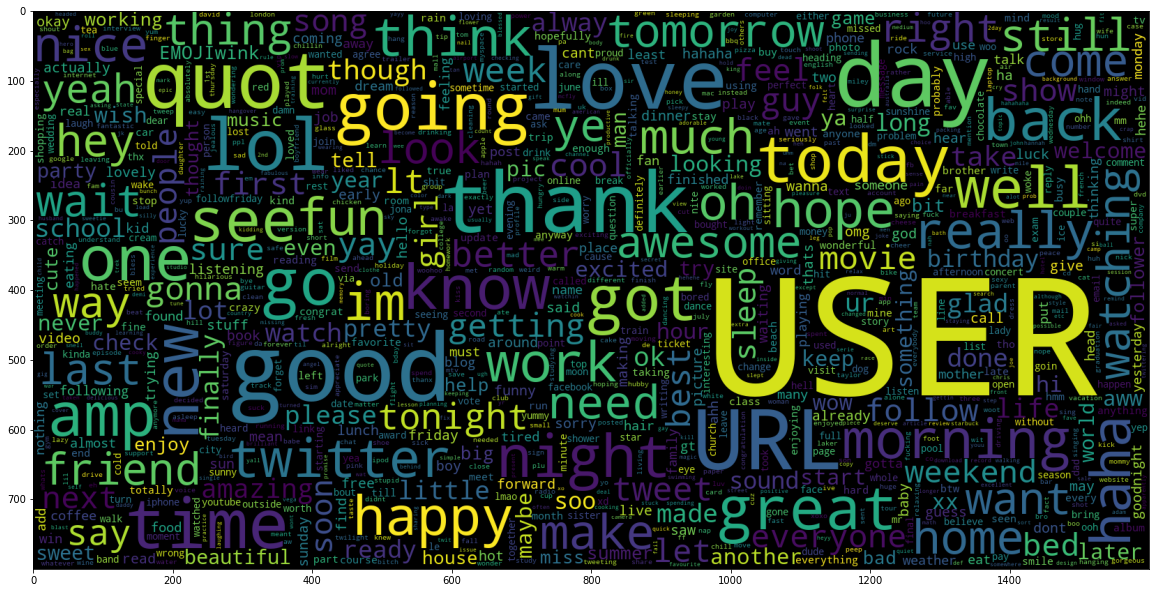

In [89]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Separação dos Dados
Iremos separar os dados para a geração do modelo e para o teste.

Definindo 90% como dados de treino e 10% como dados de teste.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.1, random_state = 0)
print(f'Separação dos dados finalizada.')

Separação dos dados finalizada.


### Vetorizador TF-IDF
O valor tf–idf, é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados. (Wikipedia)

O valor TF-IDF será utilizado para identificar os pesos de cada palavra no contexto de definir a frase como positiva ou negativa.

Utilizaremos a biblioteca sklearn que disponibiliza um vetorizador TfidVectorizer que recebe 2 parâmetros:
  - ngram_range: Número de palavras em sequência
  - max_features: Número de features a ser considerada 

In [91]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Número de features: ', len(vectoriser.get_feature_names()))

Número de features:  500000


In [92]:
# Gerando os datasets X_train e X_test que serão utilizados para treinamento e teste
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Dados de treino e teste gerados')

Dados de treino e teste gerados


### Criação do Modelo
Como utilizamos um dataset que possui 50% dos dados com um resultado e 50% com outro, podemos utilizar uma regressão logística, visto que temos dados suficientes para definir o padrão de positivo ou negativo.

A regressão logística modela resultados binomiais com uma ou mais variáveis explicativas (neste caso as palavras dentro do nosso vetor). Ela mede a relação entre a variável Y (dependente) categórica e uma ou mais variáveis X (independentes), estimando as probabilidades usando uma função logística, que é a distribuição logística cumulativa.

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     79738
           1       0.79      0.81      0.80     80262

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



Text(0.5, 1.0, 'Matriz de Confusão')

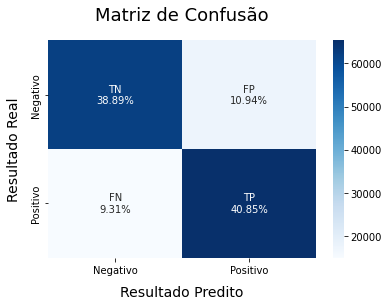

In [93]:
model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Montando a matriz de confusão pelo sklearn
cf_matrix = confusion_matrix(y_test, y_pred)

# Definindo as categorias da matriz
categories  = ['Negativo','Positivo']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Resultado Predito", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Resultado Real"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Matriz de Confusão", fontdict = {'size':18}, pad = 20)

### Usando o modelo
Agora que temos um modelo definido, que atingiu a acurácia que definimos como suficiente para nosso objeto de estudo, podemos utilizá-lo em textos de teste aleatórios, portanto sinta-se à vontade para alterar o texto dentro da variável text.

Lembrando que o texto terá de ser preprocessado da mesma forma que todos os outros textos foram antes de alimentar o algoritmo.

In [96]:
def predict(vectoriser, model, text):
    # Prediz o sentimento
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Monta a lista dos sentimmentos preditos
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Gera um pandas df com os dados
    df = pd.DataFrame(data, columns = ['Texto','Sentimento'])
    df = df.replace([0,1], ["Negativo","Positivo"])
    return df

# Texto de teste
text = ["When are you inviting us to your place? It's been so long.",
        "Today is not going to be a good day, sorry",
        "@testuser, I'd like to send you a happy new year message.",
        "The president is dead, my condolences to his family and friends.",
        "Tomorrow is going to be the best day of your life, as always! :)",
        "Please, don't talk to me anymore..."]

# Gera um dataframe com os resultados
df = predict(vectoriser, model, text)
print(df)

                                               Texto Sentimento
0  When are you inviting us to your place? It's b...   Negativo
1         Today is not going to be a good day, sorry   Negativo
2  @testuser, I'd like to send you a happy new ye...   Positivo
3  The president is dead, my condolences to his f...   Negativo
4  Tomorrow is going to be the best day of your l...   Positivo
5                Please, don't talk to me anymore...   Negativo
